## Introduction

Gaussian Neural Networks (gnn) are a class of probabilistic models that combine the flexibility of neural networks and deliver the results of gaussian processes. Here, we use gaussian neural networks and data from 2017 - 2019, 2021- 2023 (no covid) to predict the evictions for the 2024 data (up until mid-september). The model we developed is a simple, 2-hidden layer, with leaky-relu as activation function gnn. We then use the results to compare with the actual data and analyze, including mse, rmse, r-square, pearson, and spearman correlation coeffient.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [85]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

# sklearn stuff
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import scipy.stats
# import scipy.stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda import Moran_Local
from esda.getisord import G_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook

# neural net stuff
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
# gdf already cleaned
file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'

In [6]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [7]:
evictions_cleaned = evictions_cleaned_raw.copy()

In [8]:
evictions_cleaned.head()

court_index_number  docket_number    eviction_address  \
0         *313639/23           5202     710 61ST STREET   
1         *324973/22           5308     462 60TH STREET   
2          *53336/16         170279    3400 PAUL AVENUE   
3           *5990/17           2703  480 CONCORD AVENUE   
4          000098/17          69483    65 EAST 193RD ST   

  eviction_apartment_number executed_date   borough  eviction_postcode  \
0                 2ND FLOOR    2024-03-04  BROOKLYN              11220   
1      FOURTH FLOOR APT AKA    2024-08-13  BROOKLYN              11220   
2                       15D    2018-10-17     BRONX              10468   
3                        4E    2019-08-30     BRONX              10455   
4                        1B    2017-05-04     BRONX              10468   

          ejectment eviction/legal_possession   latitude  ...        bin  \
0  Not an Ejectment                Possession  40.635941  ...  3143881.0   
1  Not an Ejectment                Possession  40.640008  ...  3143435.0   
2  Not an Ejectment                Possession  40.877190  ...  2015444.0   
3  Not an Ejectment                Possession  40.811197  ...  2003900.0   
4  Not an Ejectment                Possession  40.866075  ...  2013945.0   

            bbl                         nta                      geometry  \
0  3.057940e+09            Sunset Park East  POINT (-74.011883 40.635941)   
1  3.057820e+09            Sunset Park West  POINT (-74.017068 40.640008)   
2  2.032510e+09       Van Cortlandt Village   POINT (-73.889569 40.87719)   
3  2.025770e+09      Mott Haven-Port Morris   POINT (-73.90881 40.811197)   
4  2.031770e+09  Bedford Park-Fordham North  POINT (-73.896515 40.866075)   

   eviction_count  year average_year_eviction_count cluster  cluster_k  \
0               3  2024                    3.000000       0          0   
1               3  2024                    3.000000       0          0   
2               4  2018                    4.000000       0          0   
3               9  2019                    2.250000       0          0   
4               8  2017                    2.666667       0          0   

   same_cluster  
0          True  
1          True  
2          True  
3          True  
4          True  

[5 rows x 24 columns]

In [9]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster'],
      dtype='object')

In [10]:
evictions_cleaned.shape

(76484, 24)

# Part 1:

- drop all the nans in the original dataset
- get training and testing dataset based on the year
- get X and y dataset for both training and testing (select the columns and the y)


In [11]:
# remove rows with nan values in the features
df_clean = evictions_cleaned.dropna(subset=['latitude', 'longitude', 'community_board',
                             'council_district', 'census_tract',
                             'eviction_count', 'average_year_eviction_count',
                             'cluster', 'cluster_k', 'borough'])
training_set = df_clean[
    (df_clean['year'].between(2017, 2019)) | (df_clean['year'].between(2021, 2023))
]
testing_set = df_clean[df_clean['year'] == 2024]

In [12]:
# recreate X_train and y_train from the cleaned training_set
X_data = training_set[['latitude', 'longitude', 'community_board',
                    'council_district', 'census_tract', 'cluster', 'cluster_k']].values
y_data = training_set['average_year_eviction_count'].values

In [13]:
print(training_set.shape), \
print(testing_set.shape), \
print(training_set.shape), \
print(df_clean.shape)

(64188, 24)
(9592, 24)
(64188, 24)
(76484, 24)


(None, None, None, None)

In [14]:
# recreate X_test and y_test from the cleaned training_set
X_data_test = testing_set[['latitude', 'longitude', 'community_board',
                    'council_district', 'census_tract', 'cluster', 'cluster_k']].values
y_data_test = testing_set['average_year_eviction_count'].values

# Part 2:
- process the test and train dataset, aka scale
- transform the data
- convert to tensors

In [15]:
scaler = StandardScaler()
scaler.fit(X_data)  # Fit the scaler to the data
X_data_scaled = scaler.transform(X_data)

In [16]:
scaler = StandardScaler()
scaler.fit(X_data_test)  # Fit the scaler to the data
X_data_test_scaled = scaler.transform(X_data_test)

In [17]:
# convert to PyTorch tensors
X_train = torch.tensor(X_data_scaled, dtype=torch.float32)
y_train = torch.tensor(y_data, dtype=torch.float32)
X_train.shape,\
y_train.shape

(torch.Size([64188, 7]), torch.Size([64188]))

In [18]:
# convert to PyTorch tensors
X_test = torch.tensor(X_data_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_data_test, dtype=torch.float32)
X_test.shape,\
y_test.shape

(torch.Size([9592, 7]), torch.Size([9592]))

# Part 3:

- define a simple GMNN
- define hyperparameters
- define gmnn loss
- train the model
- evaluate the model using test data
- get the results, mu, sigma, weights

In [56]:
# older version (not so good rmse)
# class GMNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, n_components):
#         # inherit GMNN to do the work
#         super(GMNN, self).__init__()
#         self.hidden = nn.Linear(input_dim, hidden_dim)
#         # means
#         self.output_mu = nn.Linear(hidden_dim, n_components)
#         # standard deviations
#         self.output_sigma = nn.Linear(hidden_dim, n_components)
#         # weights
#         self.output_weights = nn.Linear(hidden_dim, n_components)

#     def forward(self, x):
#         hidden = torch.relu(self.hidden(x))
#         mu = self.output_mu(hidden)
#         sigma = torch.exp(self.output_sigma(hidden))
#         weights = torch.softmax(self.output_weights(hidden), dim=1)
#         return mu, sigma, weights

# alternative 1: add more hidden layer
# 0.83 loss
# class GMNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, n_components):
#         super(GMNN, self).__init__()
# more layer
#         self.hidden1 = nn.Linear(input_dim, hidden_dim)
#         self.hidden2 = nn.Linear(hidden_dim, hidden_dim)


#         self.output_mu = nn.Linear(hidden_dim, n_components)
#         self.output_sigma = nn.Linear(hidden_dim, n_components)
#         self.output_weights = nn.Linear(hidden_dim, n_components)

#     def forward(self, x):
#         hidden = torch.relu(self.hidden1(x))
#         hidden = torch.relu(self.hidden2(hidden))
#         mu = self.output_mu(hidden)
#         sigma = torch.exp(self.output_sigma(hidden))
#         weights = torch.softmax(self.output_weights(hidden), dim=1)
#         return mu, sigma, weights

# alternative 2: use leaky_relu
# 0.17 loss
class GMNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(GMNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_mu = nn.Linear(hidden_dim, n_components)
        self.output_sigma = nn.Linear(hidden_dim, n_components)
        self.output_weights = nn.Linear(hidden_dim, n_components)

    def forward(self, x):
      # changed the activation function
        hidden = F.leaky_relu(self.hidden1(x))
        hidden = F.leaky_relu(self.hidden2(hidden))
        mu = self.output_mu(hidden)
        sigma = torch.exp(self.output_sigma(hidden))
        weights = torch.softmax(self.output_weights(hidden), dim=1)
        return mu, sigma, weights


## alternative 3: use batch normalization
## 0.89 loss
# class GMNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, n_components):
#         super(GMNN, self).__init__()
#         self.hidden1 = nn.Linear(input_dim, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
#         self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)
#         self.output_mu = nn.Linear(hidden_dim, n_components)
#         self.output_sigma = nn.Linear(hidden_dim, n_components)
#         self.output_weights = nn.Linear(hidden_dim, n_components)

#     def forward(self, x):
#         hidden = F.relu(self.bn1(self.hidden1(x)))
#         hidden = F.relu(self.bn2(self.hidden2(hidden)))
#         mu = self.output_mu(hidden)
#         sigma = torch.exp(self.output_sigma(hidden))
#         weights = torch.softmax(self.output_weights(hidden), dim=1)
#         return mu, sigma, weights

# alternative 4: use leaky_relu +  3 hidden layer
# 0.57 loss
# overfitting
# class GMNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, n_components):
#         super(GMNN, self).__init__()
#         self.hidden1 = nn.Linear(input_dim, hidden_dim)
#         self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
#         self.output_mu = nn.Linear(hidden_dim, n_components)
#         self.output_sigma = nn.Linear(hidden_dim, n_components)
#         self.output_weights = nn.Linear(hidden_dim, n_components)

#     def forward(self, x):
#         hidden = F.leaky_relu(self.hidden1(x))
#         hidden = F.leaky_relu(self.hidden2(hidden))
#         hidden = F.leaky_relu(self.hidden3(hidden))
#         mu = self.output_mu(hidden)
#         sigma = torch.exp(self.output_sigma(hidden))
#         weights = torch.softmax(self.output_weights(hidden), dim=1)
#         return mu, sigma, weights

In [57]:
input_dim = X_train.shape[1]
hidden_dim = 64
# number of gaussian components
n_components = 3
model = GMNN(input_dim, hidden_dim, n_components)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
# negative log-likelihood or NLL
# parameters of the GMM
# source: https://www.probabilitycourse.com/chapter4/4_2_3_normal.php
# source: https://mpatacchiola.github.io/blog/2020/07/31/gaussian-mixture-models.html
# another source: https://shuaili8.github.io/Teaching/VE445/L12_gmm.pdf

def gmnn_loss(mu, sigma, weights, y):
    # avoid division by zero
    sigma = torch.clamp(sigma, min=1e-6)
    gaussian_pdf = (1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi, dtype=torch.float32)))) * \
                   torch.exp(-0.5 * ((y.unsqueeze(1) - mu) / sigma) ** 2)
    gaussian_pdf = torch.clamp(gaussian_pdf, min=1e-6)
    mixture_pdf = torch.sum(weights * gaussian_pdf, dim=1)
    mixture_pdf = torch.clamp(mixture_pdf, min=1e-6)
    nll = -torch.log(mixture_pdf)
    return torch.mean(nll)

In [53]:
print(X_train.shape)
print(y_train.shape)

torch.Size([64188, 7])
torch.Size([64188])


In [59]:
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    mu, sigma, weights = model(X_train)
    loss = gmnn_loss(mu, sigma, weights, y_train)
    if torch.isnan(loss):
        print("nan detected")
        break
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 3.5756349563598633
Epoch 2, Loss: 3.492067813873291
Epoch 3, Loss: 3.4064555168151855
Epoch 4, Loss: 3.320725202560425
Epoch 5, Loss: 3.2371017932891846
Epoch 6, Loss: 3.1558454036712646
Epoch 7, Loss: 3.0772597789764404
Epoch 8, Loss: 3.0008010864257812
Epoch 9, Loss: 2.9244086742401123
Epoch 10, Loss: 2.8486812114715576
Epoch 11, Loss: 2.7762608528137207
Epoch 12, Loss: 2.708343029022217
Epoch 13, Loss: 2.637511968612671
Epoch 14, Loss: 2.56884765625
Epoch 15, Loss: 2.5036966800689697
Epoch 16, Loss: 2.4382472038269043
Epoch 17, Loss: 2.3730382919311523
Epoch 18, Loss: 2.312410354614258
Epoch 19, Loss: 2.258552074432373
Epoch 20, Loss: 2.213204860687256
Epoch 21, Loss: 2.1758761405944824
Epoch 22, Loss: 2.1453640460968018
Epoch 23, Loss: 2.1205015182495117
Epoch 24, Loss: 2.1001269817352295
Epoch 25, Loss: 2.083239793777466
Epoch 26, Loss: 2.0689473152160645
Epoch 27, Loss: 2.0563831329345703
Epoch 28, Loss: 2.0448200702667236
Epoch 29, Loss: 2.0336902141571045
Epoch 3

In [60]:
# evaluation
model.eval()
with torch.no_grad():
    mu, sigma, weights = model(X_test)
    test_loss = gmnn_loss(mu, sigma, weights, y_test)
    print(f"test Loss: {test_loss.item()}")

test Loss: 0.1795983910560608


In [61]:
mu
# the means of the gaussian components for each prediction
# can be interpreted as the predicted eviction risk scores.

tensor([[1.5814, 0.9808, 2.7550],
        [1.5631, 0.9764, 2.7268],
        [1.7938, 1.0129, 3.4484],
        ...,
        [1.7338, 0.9869, 3.2491],
        [1.7558, 0.9905, 3.2707],
        [1.8605, 1.0041, 3.3532]])

In [62]:
sigma
# standard deviations, indicating the uncertainty of each prediction

tensor([[0.4265, 0.0238, 0.7220],
        [0.4283, 0.0246, 0.7226],
        [0.4231, 0.0083, 0.5831],
        ...,
        [0.4270, 0.0110, 0.5857],
        [0.4252, 0.0106, 0.5830],
        [0.4215, 0.0112, 0.6237]])

In [63]:
weights
# the mixing coefficients of the Gaussian components
# show the relative importance of each gaussian distribution

tensor([[0.3595, 0.4980, 0.1425],
        [0.3585, 0.4981, 0.1434],
        [0.3186, 0.5798, 0.1016],
        ...,
        [0.3266, 0.5683, 0.1050],
        [0.3264, 0.5701, 0.1035],
        [0.3520, 0.5304, 0.1176]])

# Part 4:

- add expected risk scores back to the testing dataset
- see the distribution
- see it on the map with expected reuslts
- compare the results with the actual 2024 data (data-wise and graph-wise) (TODO)

In [64]:
# the expected eviction risk score for each sample
expected_risk_scores = torch.sum(weights * mu, dim=1).numpy()
expected_risk_scores

array([1.4495263, 1.4377618, 1.5091918, ..., 1.4685013, 1.4763021,
       1.5817206], dtype=float32)

In [65]:
testing_set.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster'],
      dtype='object')

In [66]:
# add a new column with data from expected risk scores
# then sort based on expected_risk_score
testing_set['expected_risk_score'] = expected_risk_scores
high_risk_areas = testing_set.sort_values(by='expected_risk_score', ascending=False)
# high_risk_areas[['bbl', 'nta', 'expected_risk_score']].head(20)

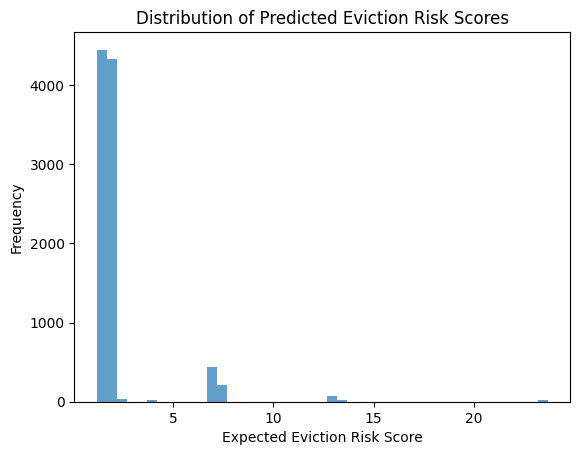

In [67]:
# to see the distribution
plt.hist(expected_risk_scores, bins=45, alpha=0.7)
plt.xlabel('Expected Eviction Risk Score')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Eviction Risk Scores')
plt.show()

In [68]:
# using folium
map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
for _, row in high_risk_areas.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        # if the expected_risk_score of the current row is greater than the 90th percentile of all risk scores, it is a high-risk area
        color='red' if row['expected_risk_score'] > np.percentile(expected_risk_scores, 90) else 'blue',
        fill=True
    ).add_to(map)

In [80]:
# map

Saving prediction2.png to prediction2.png


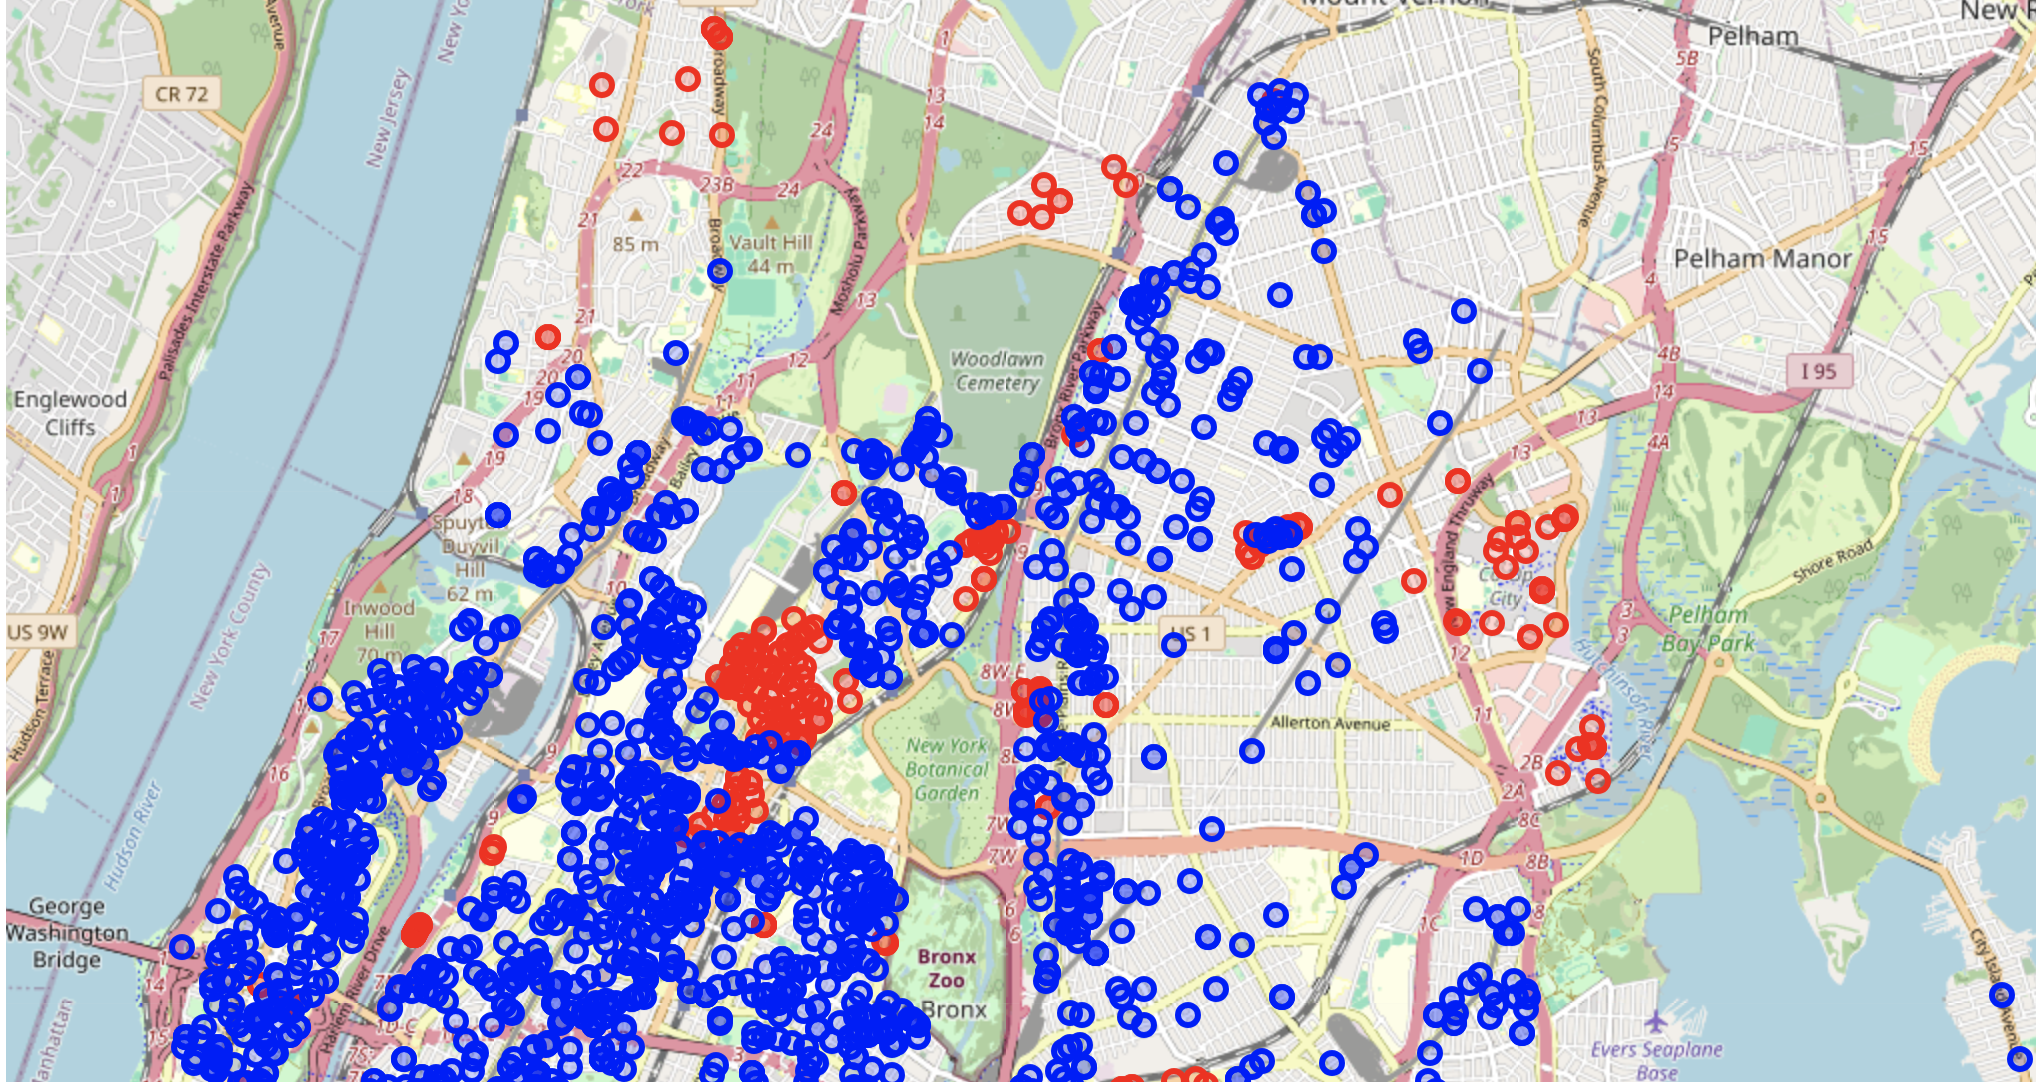

In [71]:
# one part of the map (too large)
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='prediction2.png')

### What's next?

#### need to compare with 2024 data (TODO)

In [72]:
testing_set.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster', 'expected_risk_score'],
      dtype='object')

In [73]:
# to see the real data, use "average_year_eviction_count"
average_year_eviction_counts = testing_set['average_year_eviction_count']
high_risk_areas_real = testing_set.sort_values(by='average_year_eviction_count', ascending=False)
# high_risk_areas_real[['bbl', 'nta', 'average_year_eviction_count']].head(20)

In [74]:
high_risk_areas_real.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster', 'expected_risk_score'],
      dtype='object')

In [75]:
# 2024 data
# using folium
map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
for _, row in high_risk_areas_real.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        # if the expected_risk_score of the current row is greater than the 90th percentile of all risk scores, it is a high-risk area
        color='red' if row['average_year_eviction_count'] > np.percentile(average_year_eviction_counts, 90) else 'blue',
        fill=True
    ).add_to(map)

In [ ]:
# map

Saving actual.png to actual.png


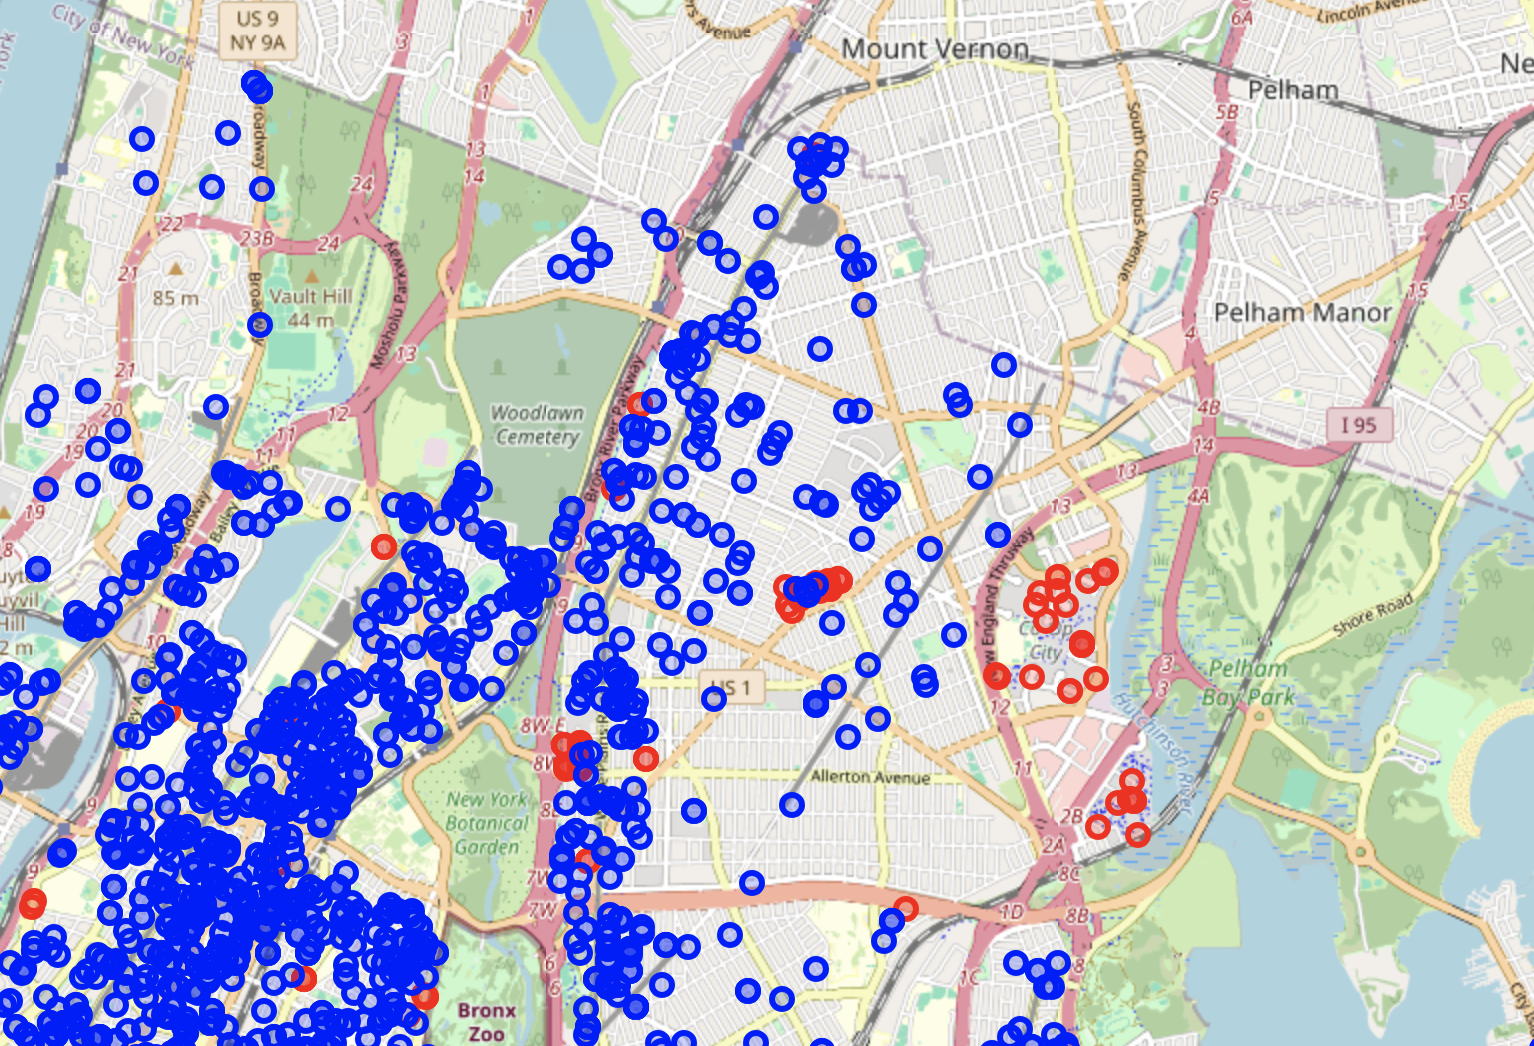

In [ ]:
# one part of the actual map
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='actual.png')

# Part 5:

- compare the expected eviction and actual eviction data

In [76]:
# convert tensors to numpy
# actual risk is from 2024 and the column average_year_eviction_count
y_test_actual = y_test.numpy()
y_predicted = expected_risk_scores

In [77]:
mean_actual = np.mean(y_test_actual)
std_actual = np.std(y_test_actual)
max_actual = np.max(y_test_actual)
min_actual = np.min(y_test_actual)
print(f"mean of actual {mean_actual}")
print(f"sd of actual {std_actual}")
print(f"max of actual {max_actual}")
print(f"min of actual {min_actual}")

mean of actual 2.365950345993042
sd of actual 3.3868162631988525
max of actual 36.28571319580078
min of actual 1.0


In [78]:
# mse
mse = mean_squared_error(y_test_actual, y_predicted)
print(f"mse is {mse}")

mse is 3.3237576484680176


In [79]:
# rmse
# better rmse with leaky_relu and 2 hidden layer
rmse = np.sqrt(mse)
print(f"rmse is {rmse}")


rmse is 1.8231176137924194


#### other measures: r2_score, correlation, residual analysis,

In [87]:
r_squared = r2_score(y_test.numpy(), expected_risk_scores)
print(f"r_squared is {r_squared}")

r_squared is 0.7102348804473877


#### captures about 71% of the data

In [91]:
# pearson and spearman correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(y_test.numpy(), expected_risk_scores)
spearman_corr, _ = scipy.stats.spearmanr(y_test.numpy(), expected_risk_scores)
print(f"pearson correlation coefficient is {pearson_corr}")
print(f"spearman correlation coefficient is {spearman_corr}")

pearson correlation coefficient is 0.8959821003274772
spearman correlation coefficient is 0.3123657342378243


#### why pearson is good, but spearman cc is not so good?

high pearson value (0.896) indicates a strong positive linear relationship between the predicted eviction and the actual ones. This means, when the predicted increase, the actuals tend to increase as well. This is a good sign that the model captures a linear relationship effectively.

However, the lower value (0.312) suggests that there is only a weak monotonic relationship between the predicted and actuals. This means, the rank order of the predictions does not correspond well with the rank order of the actual values.

Therefore, while the model does well in predicting overall trends, it struggles with ranking or distinguishing between higher and lower eviction risk values effectively.